# Задача 1. Линейная регрессия, метод градиентного спуска
Выполнила: Милосердова Любовь, 471 группа

In [70]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV

%matplotlib inline

sns.set(style="darkgrid")

* Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат.

https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview/evaluation

Data fields:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

* Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

In [2]:
train = pd.read_csv('train.csv', index_col=False)
test = pd.read_csv('test.csv', index_col=False)

del train['dropoff_datetime']

train.pickup_datetime = pd.to_datetime(train.pickup_datetime)

In [3]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Разведочный анализ данных

* Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
* При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).


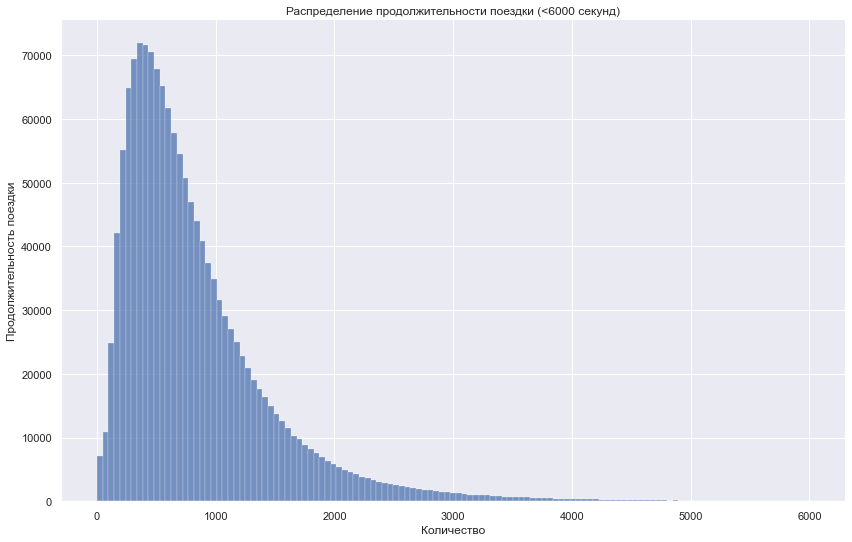

In [5]:
target_col = 'trip_duration'

g = sns.displot(train[train[target_col] < 6000],
                x=target_col,
                bins=125,
               )

fig = g.set(xlabel='Количество',
            ylabel='Продолжительность поездки',
            title='Распределение продолжительности поездки (<6000 секунд)',
           )

g.fig.set_figwidth(14)
g.fig.set_figheight(8)

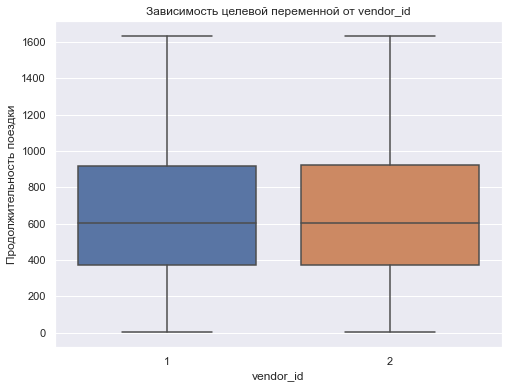

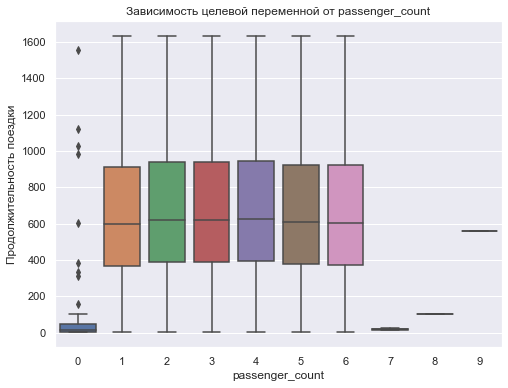

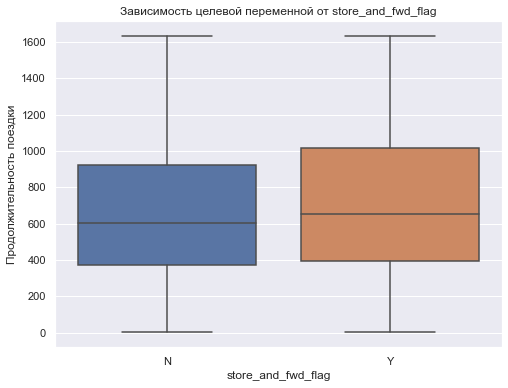

In [6]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(data=train[train.trip_duration < train.trip_duration.quantile(0.9)], x='vendor_id', y=train['trip_duration'])
g = g.set(xlabel='vendor_id',
          ylabel='Продолжительность поездки',
          title='Зависимость целевой переменной от vendor_id',
         )

plt.figure(figsize=(8, 6))
g = sns.boxplot(data=train[train.trip_duration < train.trip_duration.quantile(0.9)], x='passenger_count', y='trip_duration')
g = g.set(xlabel='passenger_count',
          ylabel='Продолжительность поездки',
          title='Зависимость целевой переменной от passenger_count',
         )

plt.figure(figsize=(8, 6))
g = sns.boxplot(data=train[train.trip_duration < train.trip_duration.quantile(0.9)], x='store_and_fwd_flag', y='trip_duration')
g = g.set(xlabel='store_and_fwd_flag',
          ylabel='Продолжительность поездки',
          title='Зависимость целевой переменной от store_and_fwd_flag',
         )

vendor_id, passenger_count, store_and_fwd_flag - плохие признаки, почти не разделют значение целевой переменной

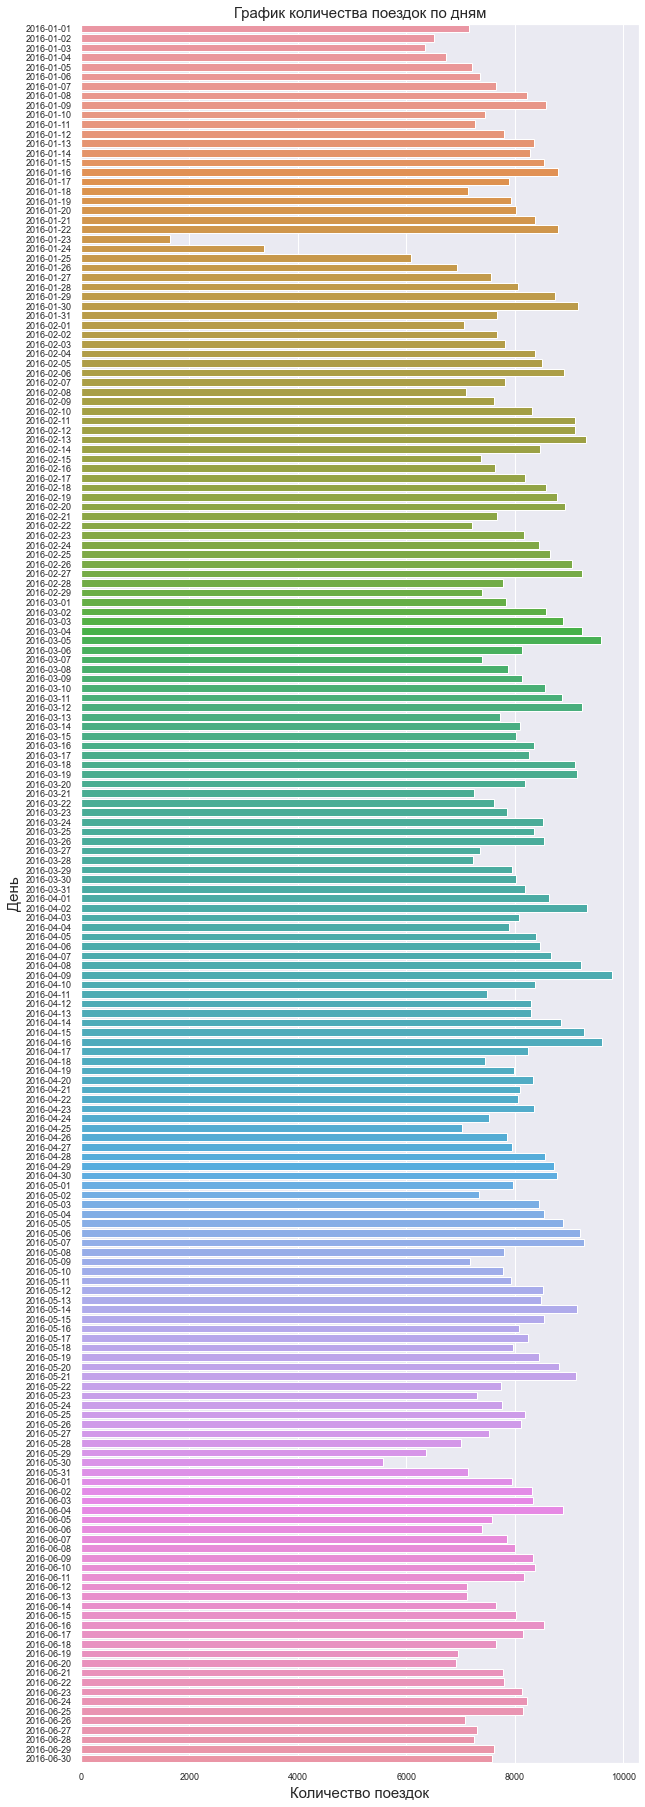

In [7]:
train['day'] = train.pickup_datetime.dt.date

plt.rcParams['figure.figsize'] = 10, 32
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['axes.labelsize'] = 15

plt.title('График количества поездок по дням', fontsize=15)
g = sns.countplot(data=train.sort_values('day'), y='day')
g = g.set(xlabel='Количество поездок', ylabel='День')

Есть несколько аномальных значений 2016-01-23 --- 2016-01-25

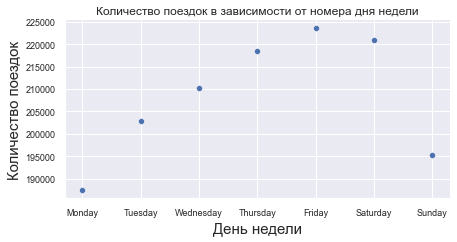

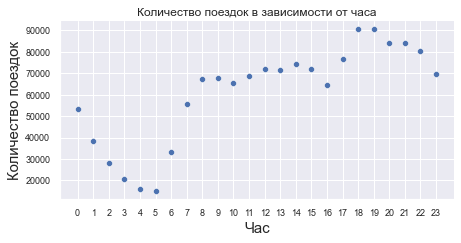

In [8]:
train['weekday'] = train.pickup_datetime.dt.weekday
train['hour'] = train.pickup_datetime.dt.hour
train['dayofyear'] = train.pickup_datetime.dt.dayofyear

weekday_sr = train.groupby('weekday')['id'].count().to_frame()
weekday_sr['day_name'] = (['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'])

g = sns.relplot(data=weekday_sr, x='day_name', y='id')
g = g.set(xlabel='День недели',
          ylabel='Количество поездок',
          title='Количество поездок в зависимости от номера дня недели',
         )
g.fig.set_figwidth(7)
g.fig.set_figheight(3)

hours_sr = train.groupby('hour')['id'].count().to_frame()
g = sns.relplot(data=hours_sr, x='hour', y='id')
g = g.set(xlabel='Час',
          ylabel='Количество поездок',
          title='Количество поездок в зависимости от часа',
         )
g.fig.set_figwidth(7)
g.fig.set_figheight(3)
g.set(xticks=np.arange(24))

In [9]:
train['abnormal_period'] = ((train.dayofyear >= 23) & (train.dayofyear <= 25))

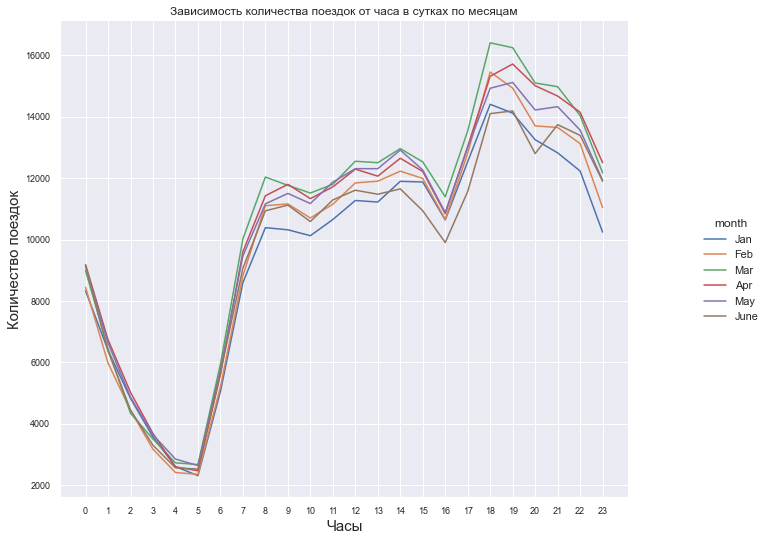

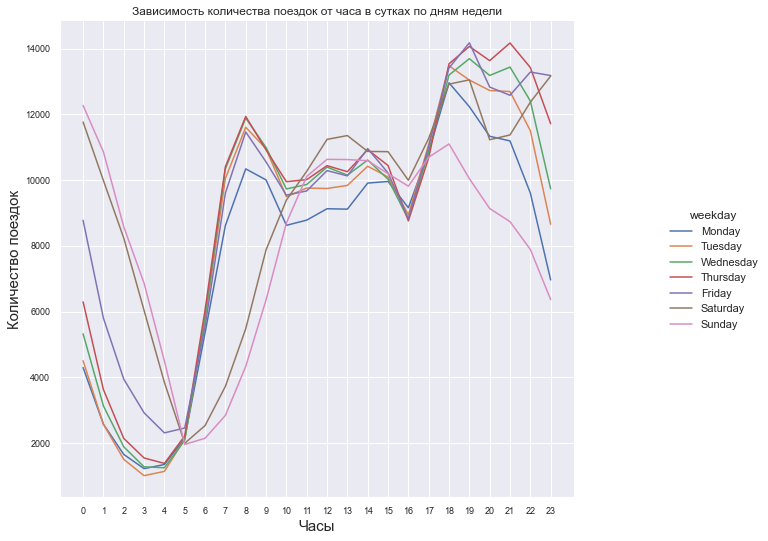

In [10]:
train['month'] = train.pickup_datetime.dt.month

hour_month_df = train.groupby(['month', 'hour'])['id'].count().to_frame()

hour_month_df.index.set_levels(['Jan','Feb','Mar','Apr','May','June'],
                                 level=0,
                                 inplace=True
                                )
g = sns.relplot(data=hour_month_df, x='hour', y='id', hue='month', kind='line')
g = g.set(xlabel='Часы',
          ylabel='Количество поездок',
          title='Зависимость количества поездок от часа в сутках по месяцам',
         )
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set(xticks=np.arange(24))

hour_weekday_df = train.groupby(['weekday', 'hour'])['id'].count().to_frame()
hour_weekday_df.index.set_levels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
                                 level=0,
                                 inplace=True
                                )
g = sns.relplot(data=hour_weekday_df, x='hour', y='id', hue='weekday', kind='line')
g = g.set(xlabel='Часы',
          ylabel='Количество поездок',
          title='Зависимость количества поездок от часа в сутках по дням недели',
         )
g.set(xticks=np.arange(24))
g.fig.set_figwidth(12)
g.fig.set_figheight(8)

Выводы: 
* количество поездок уменьшается в утренее время до 5:00 утра и резко возрастает с 5:00 до 8:00 утра, затем держится до 16:00 часов дня и достигает максимальных значений с 18:00 до 20:00

* больше всего поездок в марте и меньше всего в июне и январе

* в выходные (суббота и воскресенье) ночных поездок гораздо больше, чем в будние и наоборот дневных поездок больше в будние дни

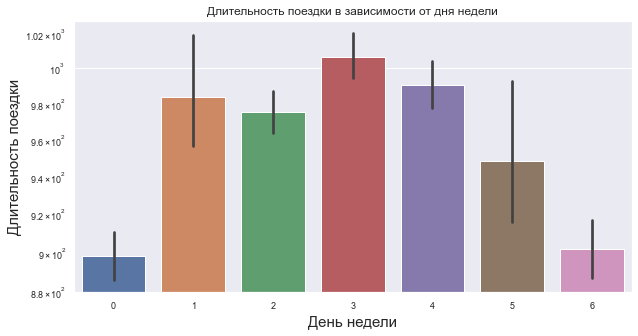

In [11]:
g = sns.barplot(data=train, x='weekday', y=target_col, log=True)
g = g.set(xlabel='День недели',
          ylabel='Длительность поездки',
          title='Длительность поездки в зависимости от дня недели',
         )
plt.gcf().set_size_inches(10,5)

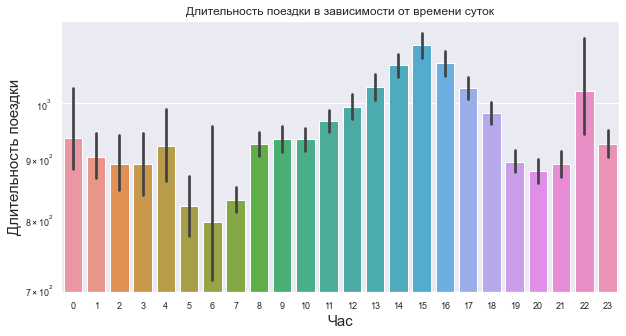

In [12]:
g = sns.barplot(data=train, x='hour', y=target_col, log=True)
g = g.set(xlabel='Час',
          ylabel='Длительность поездки',
          title='Длительность поездки в зависимости от времени суток',
         )
plt.gcf().set_size_inches(10,5)

Графики зависимости длительности поездки от дня недели и от часа в сутках похожи на аналогичные графики для количества поездок, возможно, потому что увеличивается количество машин в городе и увеличивается загруженность дорог

In [13]:
# расстояние между двумя координатами
from numpy import pi, sin, cos, arctan2, arcsin


def haversine_in_m(latitude1, longitude1, latitude2, longitude2):
    d2r = pi / 180
    longitude = (longitude2 - longitude1) * d2r
    latitude = (latitude2 - latitude1) * d2r
    a = sin(latitude / 2) ** 2 + cos(latitude1 * d2r) * cos(latitude2 * d2r) * (sin(longitude / 2) ** 2)
    c = 2 * arctan2(a ** 0.5, (1 - a) ** 0.5)
    d = 6378.1370 * c
    return d * 1000

In [14]:
train['haversine'] = haversine_in_m(train['dropoff_latitude'].values, 
                                     train['dropoff_longitude'].values,
                                     train['pickup_latitude'].values,
                                     train['pickup_longitude'].values,
                                    )

In [15]:
train['log_haversine'] = np.log1p(train['haversine'])
train['log_trip_duration'] = np.log1p(train['trip_duration'])
train[['haversine', 'log_haversine', 'trip_duration', 'log_trip_duration']].corr()

,haversine,log_haversine,trip_duration,log_trip_duration
haversine,1.000000,0.687014,0.094777,0.573595
log_haversine,0.687014,1.000000,0.085327,0.722573
trip_duration,0.094777,0.085327,1.000000,0.253521
log_trip_duration,0.573595,0.722573,0.253521,1.000000


Логарифм целевой функции гораздо лучше коррелирует с логарифмом расстояния, чем целевая функция и расстояние. Возьмем в качестве целевой функции логарифм от длительности поездки.

In [16]:
target_col = 'log_trip_duration'

## Обучение модели

* Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.

In [17]:
x = train.drop(['log_trip_duration', 'trip_duration'], axis=1)
y = train[target_col].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

* Самостоятельно реализовать функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок MSE + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.

In [34]:
def gradient_descent(X, y, learning_rate=1e-2, tol=1e-3, alpha=1, max_iters=100000, alpha_reg=1):
    weight = np.zeros(X.shape[1])
    for i in range(1, max_iters + 1):
        weight_prev = np.copy(weight)
        gradient = (1 / X.shape[0]) * (X.T.dot(X.dot(weight) - y) + alpha * weight)
        weight = weight  - learning_rate * gradient
        
        if np.linalg.norm(X.dot(weight) - X.dot(weight_prev)) < tol:
            break

    return weight

* При обучении моделей использовать масштабирование данных.

In [18]:
numeric_features = ['log_haversine', 'dayofyear', 
                    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                    'weekday', 'hour', 'month']

In [19]:
X_train_scaled = normalize(X_train[numeric_features])
X_test_scaled = normalize(X_test[numeric_features])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[numeric_features].columns) 
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test[numeric_features].columns) 

* (+1 балл) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE).


In [20]:
rfecv = RFECV(estimator=LinearRegression())

rfecv.fit(X_train_scaled.values, y_train)

selected_features = list(X_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  9
Выбранные признаки:  ['log_haversine', 'dayofyear', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'weekday', 'hour', 'month']


In [25]:
# один раз RFECV предложил удалить признак month, но в процессе улучшения модели перестал это предлагать
# X_train_scaled = X_train_scaled.drop(['month'], axis=1)
# X_test_scaled = X_test_scaled.drop(['month'], axis=1)

In [21]:
X_train_scaled.head()

,log_haversine,dayofyear,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weekday,hour,month
0,0.041378,0.718277,-0.428533,0.236061,-0.428549,0.236126,0.005793,0.052133,0.028963
1,0.070135,0.008272,-0.611952,0.337058,-0.611876,0.337411,0.033088,0.132354,0.008272
2,0.053523,0.690034,-0.443726,0.244688,-0.443200,0.244624,0.036002,0.078004,0.024001
3,0.067056,0.082317,-0.609021,0.335211,-0.608957,0.335462,0.049390,0.139940,0.008232
4,0.058649,0.420105,-0.554897,0.305842,-0.554968,0.306001,0.022506,0.127532,0.015004


 * (+1 балл) Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения всех моделей осуществить подбор оптимальных значений этих гиперпараметров.


In [24]:
alpha_grid = np.logspace(-6, 3, 10)
max_iter_grid = np.logspace(3, 7, 10)
searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid, "max_iter": max_iter_grid}], scoring="neg_root_mean_squared_error", cv=5)
_ = searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.8f" % best_alpha)
best_max_iter = searcher.best_params_["max_iter"]
print("Best max_iter = %.8f" % best_max_iter)

Best alpha = 0.01000000
Best max_iter = 1000.00000000


 * Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y). Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и $R^2$.
 

In [35]:
weight = gradient_descent(
    X_train_scaled, 
    y_train, 
    alpha=best_alpha, 
    max_iters=best_max_iter, 
    learning_rate=1, 
)
weight

log_haversine        73.702234
dayofyear             3.496784
pickup_longitude     -0.561614
pickup_latitude       0.062381
dropoff_longitude    -0.965025
dropoff_latitude     -0.056175
weekday              -1.993958
hour                  1.242109
month                 1.227339
dtype: float64

In [36]:
y_train_pred = X_train_scaled.dot(weight)
y_test_pred = X_test_scaled.dot(weight)

print("Test MSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=True))
print("Train MSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=True))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=False))
print("Test R^2 = %.8f" % r2_score(y_test, y_test_pred))
print("Train R^2 = %.8f" % r2_score(y_train, y_train_pred))

Test MSE = 0.36839475
Train MSE = 0.36704327

Test RMSE = 0.60695531
Train RMSE = 0.60584096

Test R^2 = 0.41715942
Train R^2 = 0.42082258


Не то чтобы круто получилось, данные все-таки оказались сложными, но переделывать заново на других данных не хочется. Для улучшения модели можно было бы найти координаты аэропортов (цена поездки может от этого зависеть) или придумать еще дополнительные признаки, связанные с координатами (но работать с широтой и долготой сложно, так что я не стала тратить на это время)

In [39]:
stupid_pred = y_train.mean()
print("Test MSE with stupid predictor = %.8f" % 
      mean_squared_error(y_test, stupid_pred * np.ones(y_test.shape), squared=True))
print("Train MSE with stupid predictor = %.8f\n" % 
      mean_squared_error(y_train, stupid_pred * np.ones(y_train.shape), squared=True))
print("Test RMSE with stupid predictor = %.8f" % 
      mean_squared_error(y_test, stupid_pred * np.ones(y_test.shape), squared=False))
print("Train RMSE with stupid predictor = %.8f\n" % 
      mean_squared_error(y_train, stupid_pred * np.ones(y_train.shape), squared=False))
print("Test R^2 with stupid predictor = %.8f" % 
      r2_score(y_test, stupid_pred * np.ones(y_test.shape)))
print("Train R^2 with stupid predictor = %.8f" % 
      r2_score(y_train, stupid_pred * np.ones(y_train.shape)))

Test MSE with stupid predictor = 0.63206786
Train MSE with stupid predictor = 0.63373202

Test RMSE with stupid predictor = 0.79502696
Train RMSE with stupid predictor = 0.79607287

Test R^2 with stupid predictor = -0.00000014
Train R^2 with stupid predictor = 0.00000000


* Обучить модель, используя существующую библиотеку. Например, в sklearn для $L^2$-регуляризатора можно использовать Ridge. Сравнить качество с вашей реализацией.
 

In [37]:
def get_predict(X_train, X_test, y_train, y_test, cat_features, num_features, model):
    drop_col = list(set(X_train.columns) - set(numeric_features) - set(cat_features) - set(target_col))
    
    X_train_new = X_train.drop(columns=drop_col)
    X_test_new = X_test.drop(columns=drop_col)

    model.fit(X_train_new, y_train) 
    print(model.coef_)

    y_train_pred = model.predict(X_train_new)
    y_test_pred = model.predict(X_test_new)
    
    print("Test MSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=True))
    print("Train MSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=True))
    print("Test RMSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=False))
    print("Train RMSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test R^2 = %.8f" % r2_score(y_test, y_test_pred))
    print("Train R^2 = %.8f" % r2_score(y_train, y_train_pred))

In [38]:
get_predict(
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test, 
    [], 
    numeric_features, 
    Ridge(alpha=best_alpha, tol=1e-3, max_iter=best_max_iter, fit_intercept = False)
)

[  80.406069      3.30068416    9.28236759    5.93246601  -67.70902028
 -110.54717878   -2.08845694    1.24277503    7.25627354]
Test MSE = 0.36497199
Train MSE = 0.36308115

Test RMSE = 0.60412912
Train RMSE = 0.60256215

Test R^2 = 0.42257460
Train R^2 = 0.42707463


Реализованная модель и Ridge дают близкие результаты.

## Кросс-валидация

* Повторить тоже самое, но используя кросс-валидацию.

* Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.


In [41]:
def generate_cross_validation_indices(X, y, samples_count=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    sample_size = X.shape[0] // samples_count
    batch = [0] * samples_count
    for i in range(samples_count):
        test = np.zeros(X.shape[0], dtype=bool)
        train = np.zeros(X.shape[0], dtype=bool)
        test[indices[i * sample_size:(i + 1) * sample_size]] = True
        train[indices[:i * sample_size]] = True
        train[indices[(i + 1) * sample_size:]] = True

        batch[i] = (X[train], y[train], X[test], y[test])
    return batch

### Ridge

In [111]:
model = Ridge(alpha=best_alpha, tol=1e-3, max_iter=best_max_iter)

mse_train = []
mse_test = []
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []

for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    model.fit(cur_x_train, cur_y_train)
    
    mse_train.append(mean_squared_error(cur_y_train, model.predict(cur_x_train), squared=True))
    mse_test.append(mean_squared_error(cur_y_test, model.predict(cur_x_test), squared=True))
    
    rmse_train.append(mean_squared_error(cur_y_train, model.predict(cur_x_train), squared=False))
    rmse_test.append(mean_squared_error(cur_y_test, model.predict(cur_x_test), squared=False))
    
    r2_train.append(r2_score(cur_y_train, model.predict(cur_x_train)))
    r2_test.append(r2_score(cur_y_test, model.predict(cur_x_test)))

In [112]:
folds_names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
metrics = [mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test]
result = pd.DataFrame(data=metrics, 
                      index=['MSE_train', 'MSE_test', 'RMSE_train', 'RMSE_test', 'R2_train', 'R2_test'], 
                      columns=folds_names)
result['E'] = result.mean(axis=1)
result['STD'] = result.loc[:, result.columns != 'E'].std(axis=1)
result

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,E,STD
MSE_train,0.309615,0.309645,0.309945,0.309447,0.309633,0.309657,0.000180
MSE_test,0.309830,0.309836,0.308596,0.310687,0.309907,0.309771,0.000749
RMSE_train,0.556431,0.556458,0.556727,0.556280,0.556447,0.556468,0.000162
RMSE_test,0.556623,0.556629,0.555514,0.557393,0.556693,0.556571,0.000673
R2_train,0.511561,0.510907,0.512113,0.511403,0.510889,0.511374,0.000509
R2_test,0.510617,0.513032,0.508241,0.510965,0.513062,0.511184,0.001998


Кросс-валидация помогла улучшить метрики (например, R2 приблизился к 1 на ~0.09)

### Реализованная модель

In [39]:
def get_metrics(X, y, f):
    mse_train = []
    mse_test = []
    rmse_train = []
    rmse_test = []
    r2_train = []
    r2_test = []

    for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X, y):
        weight = f(
            cur_x_train, 
            cur_y_train, 
            alpha=best_alpha, 
            max_iters=best_max_iter, 
            learning_rate=1, 
        )

        y_train_pred = cur_x_train.dot(weight)
        y_test_pred = cur_x_test.dot(weight)

        mse_train.append(mean_squared_error(cur_y_train, y_train_pred, squared=True))
        mse_test.append(mean_squared_error(cur_y_test, y_test_pred, squared=True))

        rmse_train.append(mean_squared_error(cur_y_train, y_train_pred, squared=False))
        rmse_test.append(mean_squared_error(cur_y_test, y_test_pred, squared=False))

        r2_train.append(r2_score(cur_y_train, y_train_pred))
        r2_test.append(r2_score(cur_y_test, y_test_pred))

    folds_names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
    metrics = [mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test]
    result = pd.DataFrame(data=metrics, 
                          index=['MSE_train', 'MSE_test', 'RMSE_train', 'RMSE_test', 'R2_train', 'R2_test'], 
                          columns=folds_names)
    result['E'] = result.mean(axis=1)
    result['STD'] = result.loc[:, result.columns != 'E'].std(axis=1)
    return result

In [115]:
get_metrics(X_train_scaled, y_train, gradient_descent)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,E,STD
MSE_train,0.366791,0.367872,0.366457,0.366831,0.367266,0.367043,0.000545
MSE_test,0.368052,0.363729,0.369389,0.367893,0.366153,0.367043,0.002181
RMSE_train,0.605633,0.606524,0.605357,0.605666,0.606025,0.605841,0.000450
RMSE_test,0.606673,0.603100,0.607774,0.606542,0.605106,0.605839,0.001801
R2_train,0.421667,0.419678,0.420461,0.421722,0.420582,0.420822,0.000869
R2_test,0.417430,0.425406,0.422253,0.417184,0.421786,0.420812,0.003490


Значения метрик после крос-валидации практически не изменились (но это неплохо; значит, результат стабилен относительно разбиения данных).

 * (+2 балла) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.


In [61]:
def stochastic_gradient_descent(X, y, learning_rate=1e-2, tol=1e-3, alpha=1, max_iters=100000, alpha_reg=1):
    weight = np.zeros(X.shape[1])
    for i in range(1, max_iters + 1):
        rnd = np.random.randint(0, X.shape[0])
        indices = np.zeros(X.shape[0], dtype=bool)
        indices[rnd] = True
        X_sampled = X[indices]
        y_sampled = y[indices]
        
        weight_prev = np.copy(weight)
        
        gradient = (1 / i) * (X_sampled.T.dot(X_sampled.dot(weight) - y_sampled) + alpha * weight)
        weight = weight  - learning_rate * gradient
        
        if np.linalg.norm(X.dot(weight) - X.dot(weight_prev)) < tol:
            break

    return weight

In [68]:
alpha_grid = np.logspace(-6, 3, 10)
max_iter_grid = np.logspace(3, 6, 10)
searcher = GridSearchCV(
    SGDRegressor(), 
    [{
        'alpha':alpha_grid,
        'max_iter':max_iter_grid
    }], 
    scoring="neg_root_mean_squared_error", 
    cv=5
)
_ = searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_['alpha']
print("Best alpha = %.8f" % best_alpha)
best_max_iter = searcher.best_params_['max_iter']
print("Best max_iter = %.8f" % best_max_iter)

Best alpha = 0.00000100
Best max_iter = 4641.58883361


In [53]:
best_max_iter = int(best_max_iter)

In [65]:
weight = stochastic_gradient_descent(
    X_train_scaled, 
    y_train, 
    alpha=best_alpha, 
    max_iters=best_max_iter, 
    learning_rate=1, 
)
weight

log_haversine        16.751870
dayofyear             5.119274
pickup_longitude     -2.702096
pickup_latitude       1.477213
dropoff_longitude    -2.762935
dropoff_latitude      1.461092
weekday              -1.162795
hour                  0.645061
month                 0.360224
dtype: float64

In [66]:
y_train_pred = X_train_scaled.dot(weight)
y_test_pred = X_test_scaled.dot(weight)

print("Test MSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=True))
print("Train MSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=True))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=False))
print("Test R^2 = %.8f" % r2_score(y_test, y_test_pred))
print("Train R^2 = %.8f" % r2_score(y_train, y_train_pred))

Test MSE = 1.15754523
Train MSE = 1.15658533

Test RMSE = 1.07589276
Train RMSE = 1.07544657

Test R^2 = -0.83136252
Train R^2 = -0.82503849


In [67]:
get_metrics(X_train_scaled, y_train, stochastic_gradient_descent)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,E,STD
MSE_train,0.589658,0.714572,0.919974,0.611146,1.109273,0.788925,0.221719
MSE_test,0.588196,0.715662,0.912042,0.616481,1.109600,0.788396,0.219878
RMSE_train,0.767892,0.845323,0.959153,0.781758,1.053220,0.881469,0.122149
RMSE_test,0.766939,0.845968,0.955009,0.785163,1.053376,0.881291,0.121050
R2_train,0.069802,-0.127424,-0.449272,0.033954,-0.750933,-0.244775,0.349440
R2_test,0.070818,-0.129837,-0.448828,0.033952,-0.748698,-0.244519,0.348595


Стохастический градиентный спуск на используемых данных отработал даже хуже модели, возвращающей константу.

 * (+2 балла) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.

In [43]:
def mini_batch_gradient_descent(X, y, learning_rate=1e-2, tol=1e-3, alpha=1, max_iters=100000, alpha_reg=1, batch_size=64):
    weight = np.zeros(X.shape[1])
    for i in range(1, max_iters + 1):
        indices = np.zeros(X.shape[0], dtype=bool)
        sample = np.random.choice(X.shape[0], size=batch_size, replace=False)
        indices[sample] = True
        X_sampled = X[indices]
        y_sampled = y[indices]
        
        weight_prev = np.copy(weight)
        
        gradient = (1 / len(sample)) * (X_sampled.T.dot(X_sampled.dot(weight) - y_sampled) + alpha * weight)
        weight = weight  - learning_rate * gradient
        
        if np.linalg.norm(X.dot(weight) - X.dot(weight_prev)) < tol:
            break

    return weight

In [44]:
weight = mini_batch_gradient_descent(
    X_train_scaled, 
    y_train, 
    alpha=best_alpha, 
    max_iters=best_max_iter, 
    learning_rate=1, 
)
weight

log_haversine        16.870512
dayofyear             3.555910
pickup_longitude     -2.807231
pickup_latitude       1.532992
dropoff_longitude    -2.866702
dropoff_latitude      1.537170
weekday              -0.746812
hour                  1.179119
month                 0.242167
dtype: float64

In [45]:
y_train_pred = X_train_scaled.dot(weight)
y_test_pred = X_test_scaled.dot(weight)

print("Test MSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=True))
print("Train MSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=True))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE = %.8f\n" % mean_squared_error(y_train, y_train_pred, squared=False))
print("Test R^2 = %.8f" % r2_score(y_test, y_test_pred))
print("Train R^2 = %.8f" % r2_score(y_train, y_train_pred))

Test MSE = 0.56620431
Train MSE = 0.56672176

Test RMSE = 0.75246548
Train RMSE = 0.75280924

Test R^2 = 0.10420317
Train R^2 = 0.10573912


In [46]:
get_metrics(X_train_scaled, y_train, mini_batch_gradient_descent)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,E,STD
MSE_train,0.567673,0.566816,0.567086,0.566248,0.568053,0.567175,0.000710
MSE_test,0.571780,0.568290,0.565446,0.567344,0.563562,0.567284,0.003101
RMSE_train,0.753441,0.752872,0.753051,0.752495,0.753693,0.753110,0.000471
RMSE_test,0.756162,0.753850,0.751961,0.753222,0.750708,0.753181,0.002058
R2_train,0.102854,0.105212,0.105554,0.106086,0.105407,0.105022,0.001255
R2_test,0.103278,0.104783,0.106192,0.106358,0.103611,0.104844,0.001422


Мини-пакетный градиентный спуск показал себя хуже, чем обычный градиентный спуск.